In [ ]:
# Colab-friendly installs
%pip install -q tensorflow  
%pip install -q nodevectors  
%pip install -q scipy
%pip install -q networkx pandas numpy scikit-learn matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Loading all graphs...
Loading /Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2000.net
Loading /Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2005.net
Loading /Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2010.net
Loading /Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2015.net
Loading /Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2018.net
2000: nodes=161, edges=16335
2005: nodes=161, edges=17201
2010: nodes=161, edges=18579
2015: nodes=161, edges=18061
2018: nodes=161, edges=17030
Nodes common to all years: 161
Computing layout (spring) for consistent plotting...


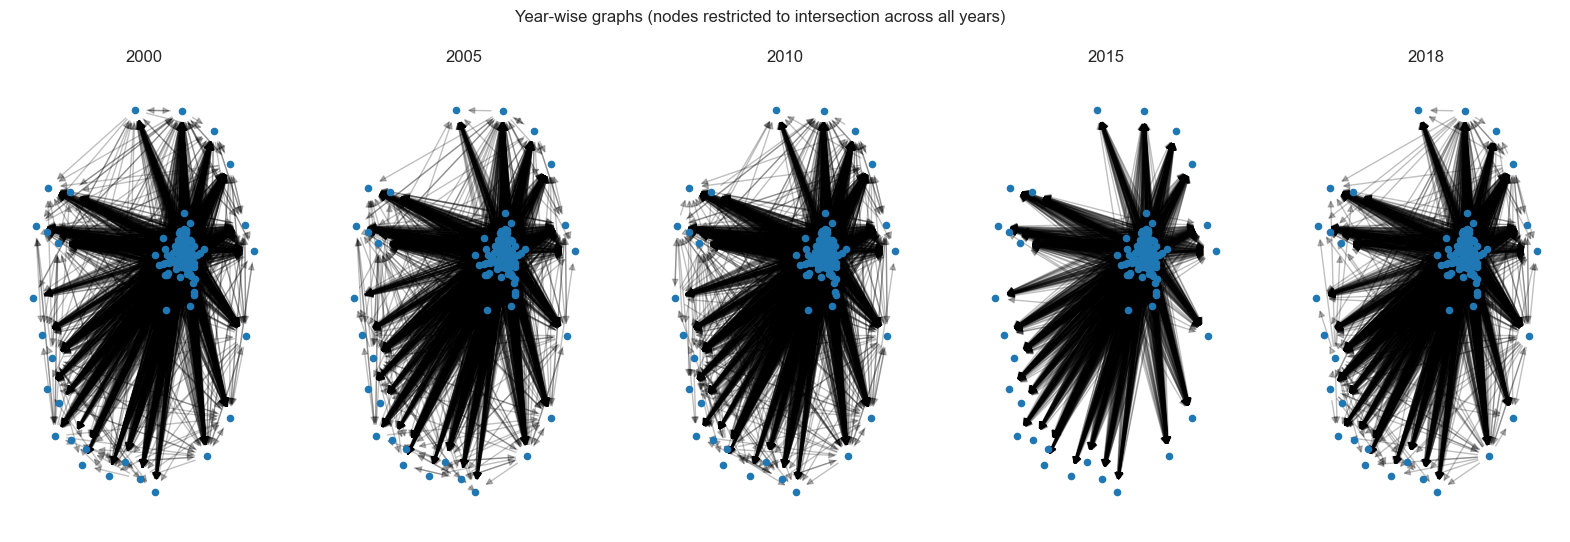

In [57]:
import os, itertools, time, warnings
warnings.filterwarnings("ignore")

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from tabulate import tabulate

# Paths (use uploaded files)
PATHS = {
    "2000": "/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2000.net",
    "2005": "/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2005.net",
    "2010": "/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2010.net",
    "2015": "/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2015.net",
    "2018": "/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2018.net"
}

# ---------------- Helper functions ----------------
def load_pajek_graph(path):
    """Load Pajek .net into a simple DiGraph (aggregate duplicate edges)."""
    print("Loading", path)
    Gm = nx.read_pajek(path)
    G = nx.DiGraph()
    for u,v,data in Gm.edges(data=True):
        weight = data.get('weight', 1.0) if isinstance(data, dict) else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += weight
        else:
            G.add_edge(u,v, weight=weight)
    return G

def nodes_intersection(graphs):
    """Return sorted intersection of node sets across list of graphs."""
    sets = [set(G.nodes()) for G in graphs]
    inter = set.intersection(*sets)
    return sorted(list(inter))

def build_node_features(G, nodes):
    """Return features matrix N x F for the provided ordered nodes: normalized degree + clustering."""
    deg = np.array([G.degree(n) for n in nodes], dtype=float)
    clustering = np.array([nx.clustering(G.to_undirected(), n) for n in nodes], dtype=float)
    if deg.max() > 0:
        deg = deg / deg.max()
    feats = np.vstack([deg, clustering]).T
    return feats

def build_adj_matrix(G, nodes):
    """Adjacency matrix aligned to nodes ordering."""
    idx = {n:i for i,n in enumerate(nodes)}
    N = len(nodes)
    A = np.zeros((N,N), dtype=float)
    for u,v,data in G.edges(data=True):
        if u in idx and v in idx:
            A[idx[u], idx[v]] = data.get('weight', 1.0) if isinstance(data, dict) else 1.0
    return A

def extract_pair_features_for_pairs(G, nodes, pairs):
    """Compute handcrafted features for a list of ordered node pairs (u,v) (used for ML baseline).
    Returns X (n_pairs x features) and optionally list of pairs."""
    G_undir = G.to_undirected()
    rows = []
    for (u,v) in pairs:
        prev_weight = G[u][v]['weight'] if G.has_edge(u,v) else 0
        common_neigh = len(list(nx.common_neighbors(G_undir,u,v)))
        preds_j = list(nx.jaccard_coefficient(G_undir, [(u,v)]))
        jaccard_score = preds_j[0][2] if preds_j else 0
        preds_aa = list(nx.adamic_adar_index(G_undir, [(u,v)]))
        adamic_adar = preds_aa[0][2] if preds_aa else 0
        pref_attach = G_undir.degree(u) * G_undir.degree(v)
        rows.append([prev_weight, common_neigh, jaccard_score, adamic_adar, pref_attach])
    X = np.array(rows, dtype=float)
    return X

# ------------- 1) Load all graphs and show year-wise graphs -------------
print("Loading all graphs...")
G2000 = load_pajek_graph(PATHS["2000"])
G2005 = load_pajek_graph(PATHS["2005"])
G2010 = load_pajek_graph(PATHS["2010"])
G2015 = load_pajek_graph(PATHS["2015"])
G2018 = load_pajek_graph(PATHS["2018"])

graphs = [G2000, G2005, G2010, G2015, G2018]
years = ["2000","2005","2010","2015","2018"]
for y,G in zip(years, graphs):
    print(f"{y}: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

# Use intersection of nodes present in all snapshots (ensures alignment)
common_nodes = nodes_intersection(graphs)
print("Nodes common to all years:", len(common_nodes))

# If intersection is empty (rare), fall back to nodes of 2015
if len(common_nodes) == 0:
    print("Warning: no common nodes across all years. Falling back to nodes of 2015.")
    common_nodes = sorted(list(G2015.nodes()))

# compute a consistent layout (spring based on 2015) for all visualisations
print("Computing layout (spring) for consistent plotting...")
pos = nx.spring_layout(G2015, seed=42, iterations=50)

# Plot year-wise graphs (only nodes in common_nodes for direct visual comparison)
plt.figure(figsize=(20,6))
for i, (G,y) in enumerate(zip(graphs, years)):
    plt.subplot(1,5,i+1)
    subG = G.subgraph(common_nodes).copy()
    nx.draw_networkx_nodes(subG, pos, node_size=20)
    nx.draw_networkx_edges(subG, pos, alpha=0.25)
    plt.title(y)
    plt.axis('off')
plt.suptitle("Year-wise graphs (nodes restricted to intersection across all years)")
plt.show()

## Machine Learning Method

In [67]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import itertools

def load_pajek_graph(filepath):
    """
    Loads a Pajek .net file into a NetworkX DiGraph.
    Handles potential parsing quirks by forcing a Directed Graph.
    """
    try:
        # networkx read_pajek returns a MultiGraph or MultiDiGraph usually
        G_multi = nx.read_pajek(filepath)
        # Convert to a simple Directed Graph (summing weights if duplicates exist)
        G = nx.DiGraph()
        for u, v, data in G_multi.edges(data=True):
            weight = data.get('weight', 1.0)
            if G.has_edge(u, v):
                G[u][v]['weight'] += weight
            else:
                G.add_edge(u, v, weight=weight)
        return G
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

def extract_features(G_current, target_edges_set):
    """
    Generates a dataset for link prediction.
    Rows: All possible pairs of nodes.
    Columns: Topological features + Previous Weight.
    Target: 1 if link exists in the 'future' (target_edges_set), else 0.
    """
    
    # Get all unique nodes (countries)
    nodes = sorted(list(G_current.nodes()))
    
    # Create an undirected view for calculation of specific metrics
    # (Jaccard and Adamic-Adar are typically defined for undirected neighbors)
    G_undir = G_current.to_undirected()
    
    data = []
    
    # Iterate through all possible pairs (u, v)
    # We use permutations because direction matters (Arg -> Bra is different from Bra -> Arg)
    for u, v in itertools.permutations(nodes, 2):
        
        # 1. Feature: Weight in the current graph (Temporal persistence)
        # If they are already connected, how strong is it?
        prev_weight = G_current[u][v]['weight'] if G_current.has_edge(u, v) else 0
        
        # 2. Feature: Common Neighbors (Undirected count is usually robust for trade)
        common_neigh = len(list(nx.common_neighbors(G_undir, u, v)))
        
        # 3. Feature: Jaccard Coefficient
        preds_jaccard = list(nx.jaccard_coefficient(G_undir, [(u, v)]))
        jaccard_score = preds_jaccard[0][2] if preds_jaccard else 0
        
        # 4. Feature: Adamic-Adar Index (Resource allocation)
        preds_aa = list(nx.adamic_adar_index(G_undir, [(u, v)]))
        adamic_adar = preds_aa[0][2] if preds_aa else 0
        
        # 5. Feature: Preferential Attachment (Degree product)
        pref_attach = G_undir.degree(u) * G_undir.degree(v)
        
        # --- TARGET VARIABLE ---
        # Does this link exist in the FUTURE graph?
        label = 1 if (u, v) in target_edges_set else 0
        
        data.append([u, v, prev_weight, common_neigh, jaccard_score, adamic_adar, pref_attach, label])
        
    df = pd.DataFrame(data, columns=['u', 'v', 'prev_weight', 'common_neighbors', 
                                     'jaccard', 'adamic_adar', 'pref_attach', 'label'])
    return df

# --- MAIN EXECUTION ---

# 1. Load the graphs
print("Loading graphs...")
G_2010 = load_pajek_graph('/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2010.net')
G_2015 = load_pajek_graph('/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2015.net')
G_2018 = load_pajek_graph('/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2018.net')

# Ensure we loaded correctly
if G_2010 and G_2015 and G_2018:
    print(f"Nodes in 2010: {len(G_2010.nodes())}, Edges: {len(G_2010.edges())}")
    
    # 2. Prepare Training Data (Learn from 2010 -> 2015 evolution)
    print("Preparing Training Data (2010 -> 2015)...")
    # Set of edges in 2015 for fast lookup
    edges_2015 = set(G_2015.edges())
    train_df = extract_features(G_2010, edges_2015)
    
    # 3. Prepare Test Data (Predict 2015 -> 2018 evolution)
    print("Preparing Test Data (2015 -> 2018)...")
    edges_2018 = set(G_2018.edges())
    test_df = extract_features(G_2015, edges_2018)

    # 4. Train Model
    features = ['prev_weight', 'common_neighbors', 'jaccard', 'adamic_adar', 'pref_attach']
    
    X_train = train_df[features]
    y_train = train_df['label']
    
    X_test = test_df[features]
    y_test = test_df['label']
    
    print("Training Random Forest Classifier...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    # 5. Evaluate
    print("Evaluating on 2018 predictions...")
    y_pred_proba = clf.predict_proba(X_test)[:, 1] # Probability of link existing
    y_pred = clf.predict(X_test)
    
    # Metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\n--- Results ---")
    print(f"ROC-AUC Score: {auc:.4f} (Higher is better, 0.5 is random guessing)")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 6. Feature Importance
    importances = clf.feature_importances_
    print("\nFeature Importance:")
    for name, imp in zip(features, importances):
        print(f"{name}: {imp:.4f}")

else:
    print("Failed to load one or more graphs. Please check file paths.")

Loading graphs...
Nodes in 2010: 161, Edges: 18579
Preparing Training Data (2010 -> 2015)...
Preparing Test Data (2015 -> 2018)...
Training Random Forest Classifier...
Evaluating on 2018 predictions...

--- Results ---
ROC-AUC Score: 0.8007 (Higher is better, 0.5 is random guessing)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      8730
           1       0.80      0.88      0.84     17030

    accuracy                           0.78     25760
   macro avg       0.76      0.73      0.74     25760
weighted avg       0.77      0.78      0.77     25760


Feature Importance:
prev_weight: 0.3655
common_neighbors: 0.0604
jaccard: 0.0990
adamic_adar: 0.2493
pref_attach: 0.2258


Reconstructing Predicted Graph...


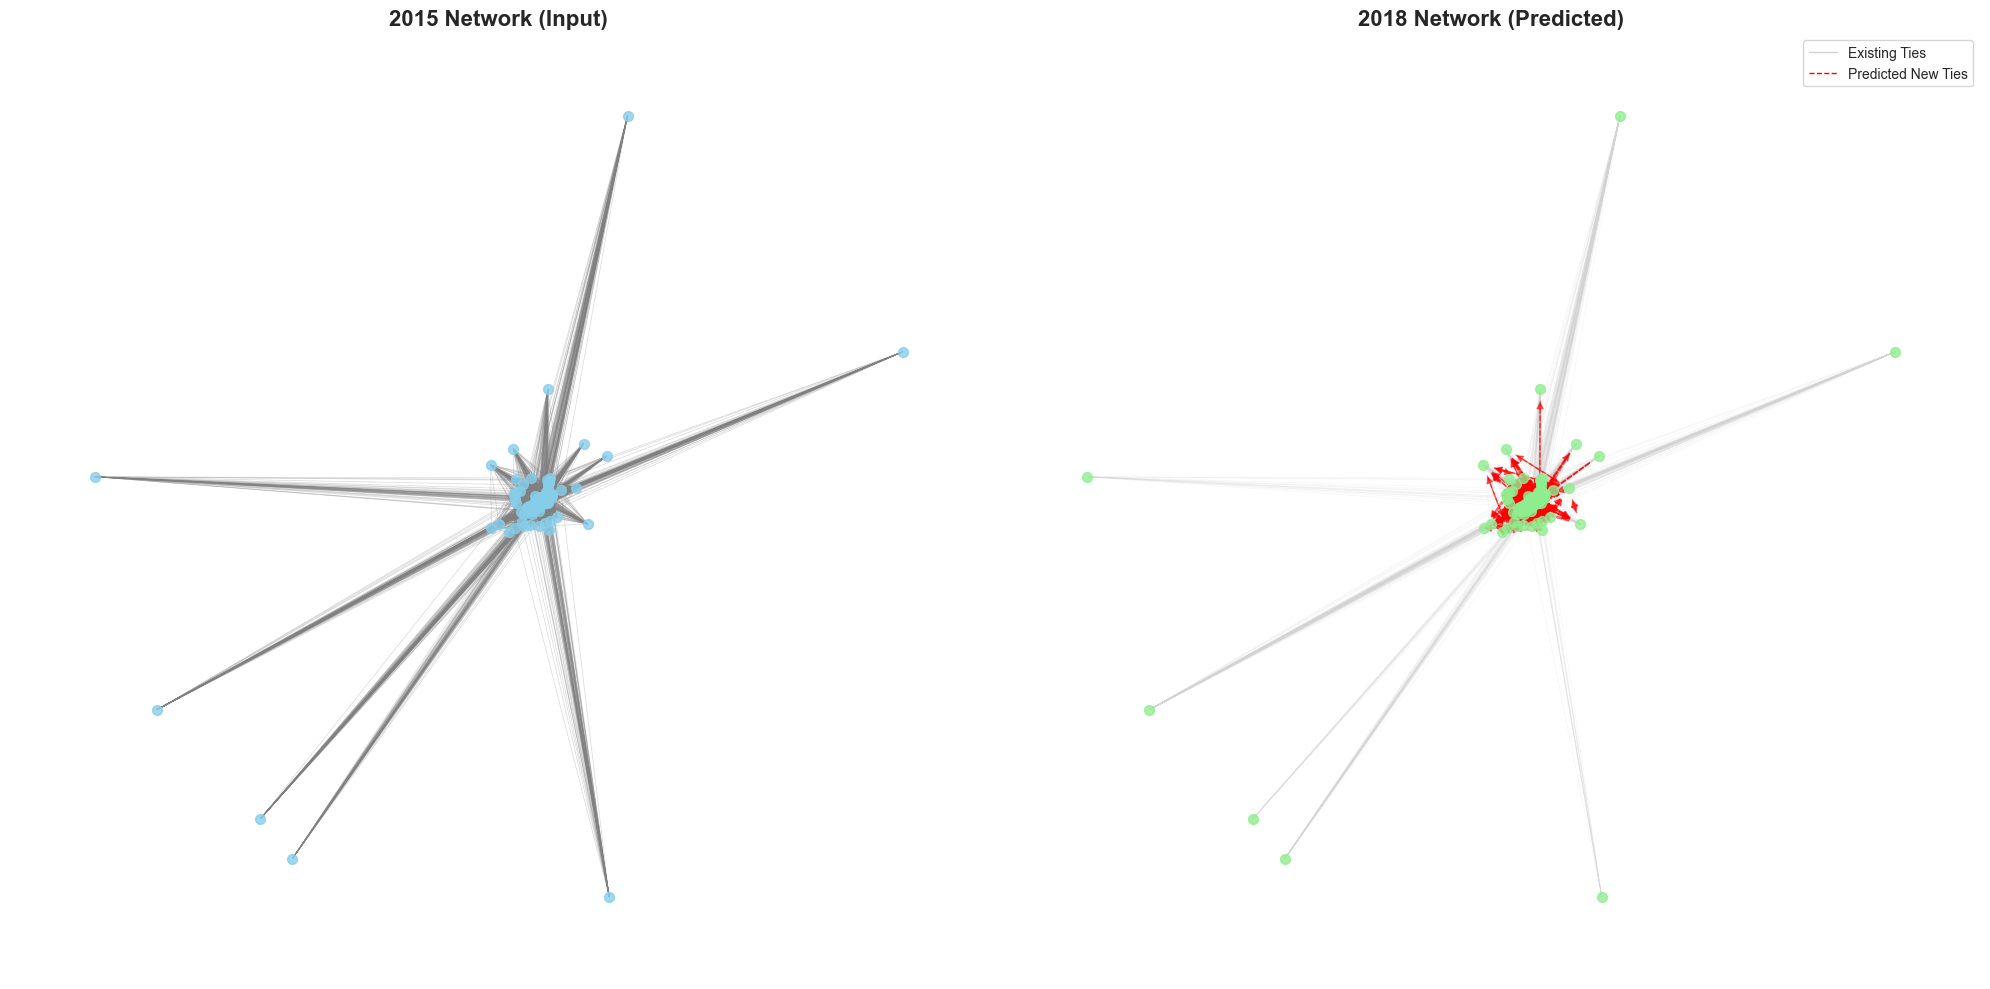

In [68]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_prediction(G_past, G_future_predicted, title_before, title_after, new_link_threshold=0.5):
    """
    Visualizes the evolution of the network.
    
    Args:
    - G_past: The graph at time T (e.g., 2015)
    - G_future_predicted: The graph with predicted edges for T+1
    - title_before: Title for the first plot
    - title_after: Title for the second plot
    """
    
    # 1. Setup the Layout (Keep node positions constant for comparison)
    # We use the union of both graphs to ensure all nodes have a fixed place
    G_combined = nx.compose(G_past, G_future_predicted)
    # k controls the spacing (higher = more spread out)
    pos = nx.spring_layout(G_combined, seed=42, k=0.15) 

    # --- PLOT 1: BEFORE (The Past Graph) ---
    plt.figure(figsize=(20, 10))
    
    # Left Subplot: Before
    plt.subplot(1, 2, 1)
    plt.title(title_before, fontsize=16, fontweight='bold')
    
    # Draw nodes
    nx.draw_networkx_nodes(G_past, pos, node_size=50, node_color='skyblue', alpha=0.8)
    
    # Draw edges (Past links are solid gray)
    nx.draw_networkx_edges(G_past, pos, edge_color='gray', alpha=0.3, width=0.5, arrows=False)
    
    # Draw labels (optional, can be cluttered for 161 nodes)
    # nx.draw_networkx_labels(G_past, pos, font_size=8)
    plt.axis('off')

    # --- PLOT 2: AFTER (The Predicted Graph) ---
    # We want to distinguish between "Old Links" (persisted) and "New Links" (predicted)
    plt.subplot(1, 2, 2)
    plt.title(title_after, fontsize=16, fontweight='bold')

    # Identify New Links: Edges in Predicted that were NOT in Past
    past_edges = set(G_past.edges())
    predicted_edges = set(G_future_predicted.edges())
    new_edges = list(predicted_edges - past_edges)
    persisted_edges = list(predicted_edges & past_edges)

    # Draw nodes
    nx.draw_networkx_nodes(G_future_predicted, pos, node_size=50, node_color='lightgreen', alpha=0.8)

    # Draw OLD edges (Background, Gray)
    nx.draw_networkx_edges(G_future_predicted, pos, edgelist=persisted_edges, 
                           edge_color='lightgray', alpha=0.2, width=0.5, arrows=False)

    # Draw NEW PREDICTED edges (Foreground, Red)
    if new_edges:
        nx.draw_networkx_edges(G_future_predicted, pos, edgelist=new_edges, 
                               edge_color='red', alpha=0.6, width=1.0, style='dashed')

    plt.axis('off')
    
    # Add a legend for the second plot
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='lightgray', lw=1),
                    Line2D([0], [0], color='red', lw=1, linestyle='--')]
    plt.legend(custom_lines, ['Existing Ties', 'Predicted New Ties'], loc='upper right')

    plt.tight_layout()
    plt.show()

# --- HOW TO RUN THIS WITH YOUR PREVIOUS CODE ---

# 1. Reconstruct the "Predicted Graph" from the model output
# (Assuming 'clf' is your trained model and 'test_df' is your prepared data)
print("Reconstructing Predicted Graph...")

# Get predictions (0 or 1)
predictions = clf.predict(X_test)

# Create a new graph for 2018 (Predicted)
G_2018_Predicted = nx.DiGraph()
G_2018_Predicted.add_nodes_from(G_2015.nodes()) # Start with same nodes

# Add edges where prediction == 1
# 'test_df' has columns ['u', 'v', ...] and we align it with 'predictions'
for index, row in test_df.iterrows():
    u, v = row['u'], row['v']
    # The dataframe index corresponds to the predictions array index
    if predictions[index] == 1:
        G_2018_Predicted.add_edge(u, v)

# 2. Run the Visualization
# This will show 2015 on the left and Predicted 2018 on the right
visualize_prediction(G_2015, G_2018_Predicted, 
                     title_before="2015 Network (Input)", 
                     title_after="2018 Network (Predicted)")

Computing layout...


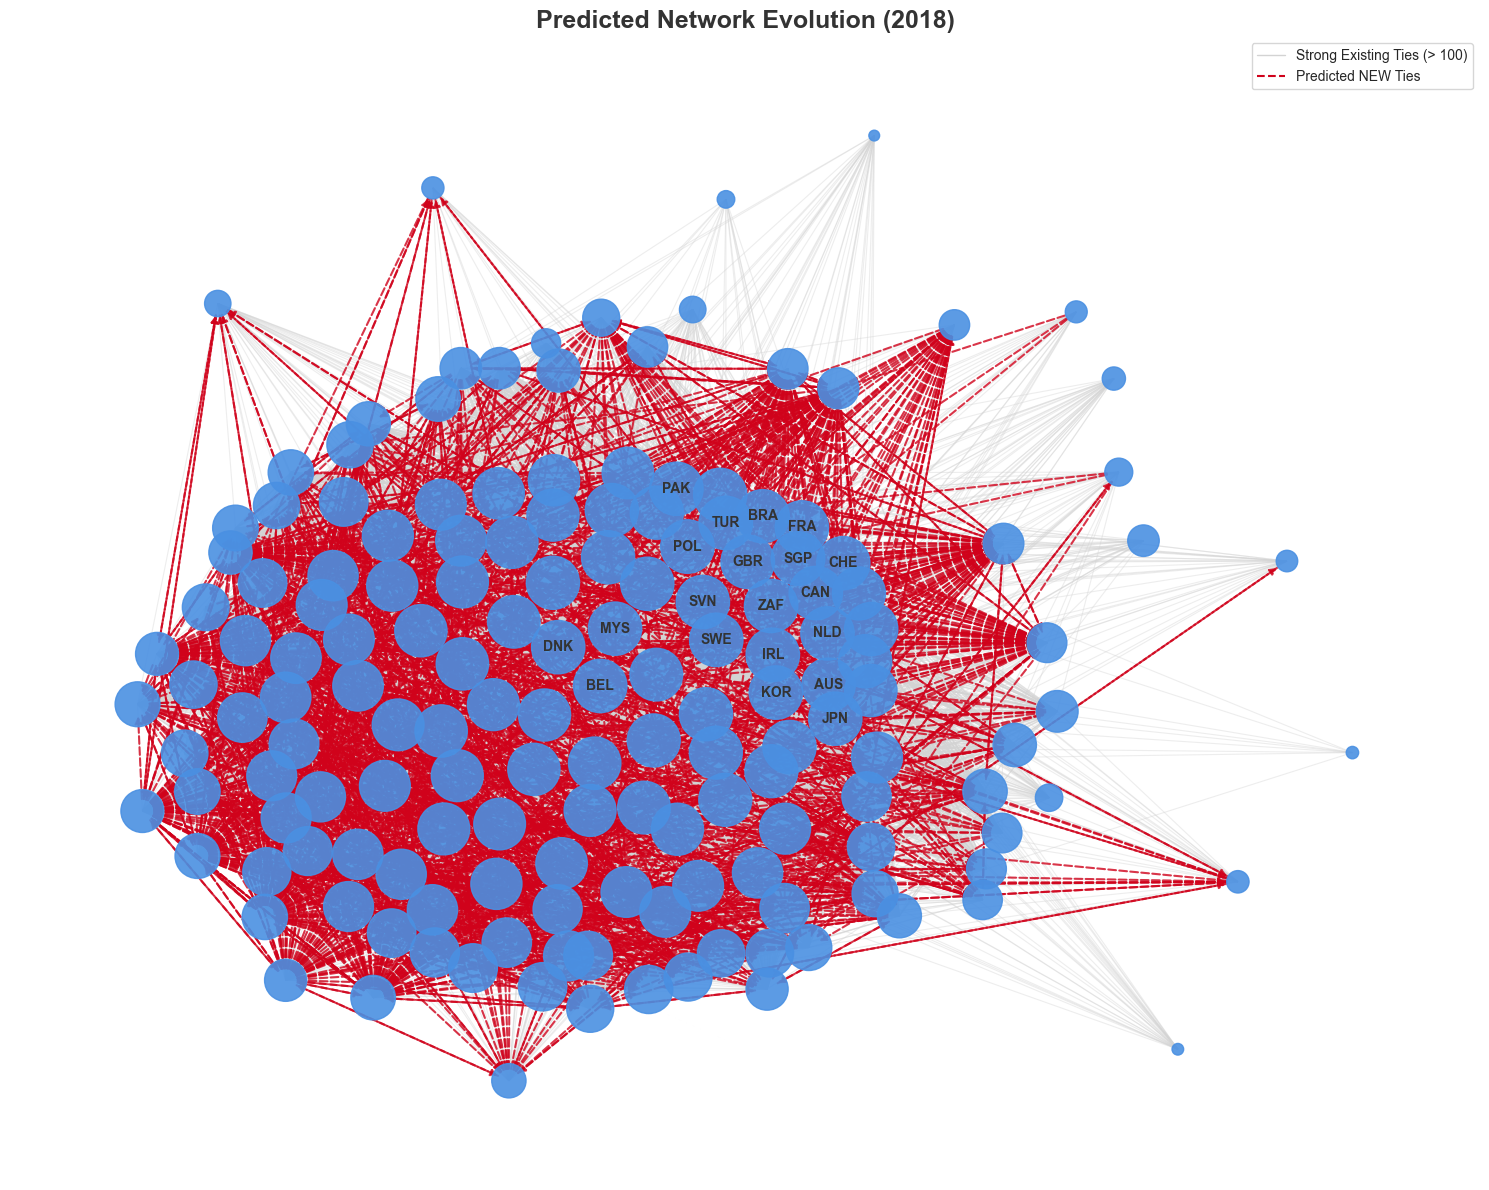

In [69]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_clearer_prediction(G_past, G_future_predicted, title, min_weight_threshold=100):
    """
    Visualizes the network with filters to reduce clutter.
    
    Args:
    - min_weight_threshold: Only show PAST edges if weight > this value. 
                            (Adjust this based on your data! Try 10, 100, or 1000)
    """
    plt.figure(figsize=(15, 12))
    
    # 1. layout: Kamada-Kawai is often better for separating clusters than Spring
    # We calculate layout on the full predicted graph
    print("Computing layout...")
    pos = nx.kamada_kawai_layout(G_future_predicted) 

    # 2. Separate Edges for Plotting
    past_edges = G_past.edges(data=True)
    predicted_edges = G_future_predicted.edges()
    
    # FILTER 1: existing_strong_edges (Background)
    # Only draw existing edges if they are "strong" (weight > threshold)
    existing_strong_edges = [
        (u, v) for u, v, d in past_edges 
        if d.get('weight', 0) > min_weight_threshold
    ]
    
    # FILTER 2: new_predicted_edges (Foreground)
    # Edges that are in Future but NOT in Past
    past_edge_set = set(G_past.edges())
    new_predicted_edges = [
        (u, v) for u, v in predicted_edges 
        if (u, v) not in past_edge_set
    ]

    # 3. Draw the Graph
    plt.title(title, fontsize=18, fontweight='bold', color='#333333')

    # Draw Nodes (Size based on degree/importance)
    d = dict(G_future_predicted.degree)
    node_sizes = [v * 5 for v in d.values()] # Scale node size by connections
    nx.draw_networkx_nodes(G_future_predicted, pos, node_size=node_sizes, node_color='#4A90E2', alpha=0.9)

    # Draw Background Edges (Stable, Strong Ties) - Thin and Gray
    nx.draw_networkx_edges(G_future_predicted, pos, edgelist=existing_strong_edges, 
                           edge_color='lightgray', alpha=0.4, width=0.8, arrows=False)

    # Draw New Predicted Edges (The Insight) - Red and Prominent
    nx.draw_networkx_edges(G_future_predicted, pos, edgelist=new_predicted_edges, 
                           edge_color='#D0021B', alpha=0.8, width=1.5, style='dashed')

    # 4. Smart Labeling (Only label top 20 hubs to avoid text mess)
    # Sort nodes by degree
    sorted_nodes = sorted(G_future_predicted.degree, key=lambda x: x[1], reverse=True)
    top_hubs = [n for n, deg in sorted_nodes[:20]] 
    
    # Create a label dictionary just for top hubs
    labels = {n: n for n in top_hubs}
    nx.draw_networkx_labels(G_future_predicted, pos, labels, font_size=10, font_weight='bold', font_color='#333333')

    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='lightgray', lw=1, label=f'Strong Existing Ties (> {min_weight_threshold})'),
        Line2D([0], [0], color='#D0021B', lw=1.5, linestyle='--', label='Predicted NEW Ties')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- RUN THIS ---
# You might need to experiment with 'min_weight_threshold'. 
# Since your data has weights like 25875 and 0.345, try 100 or 1000 first.
visualize_clearer_prediction(G_2015, G_2018_Predicted, 
                             "Predicted Network Evolution (2018)", 
                             min_weight_threshold=100)

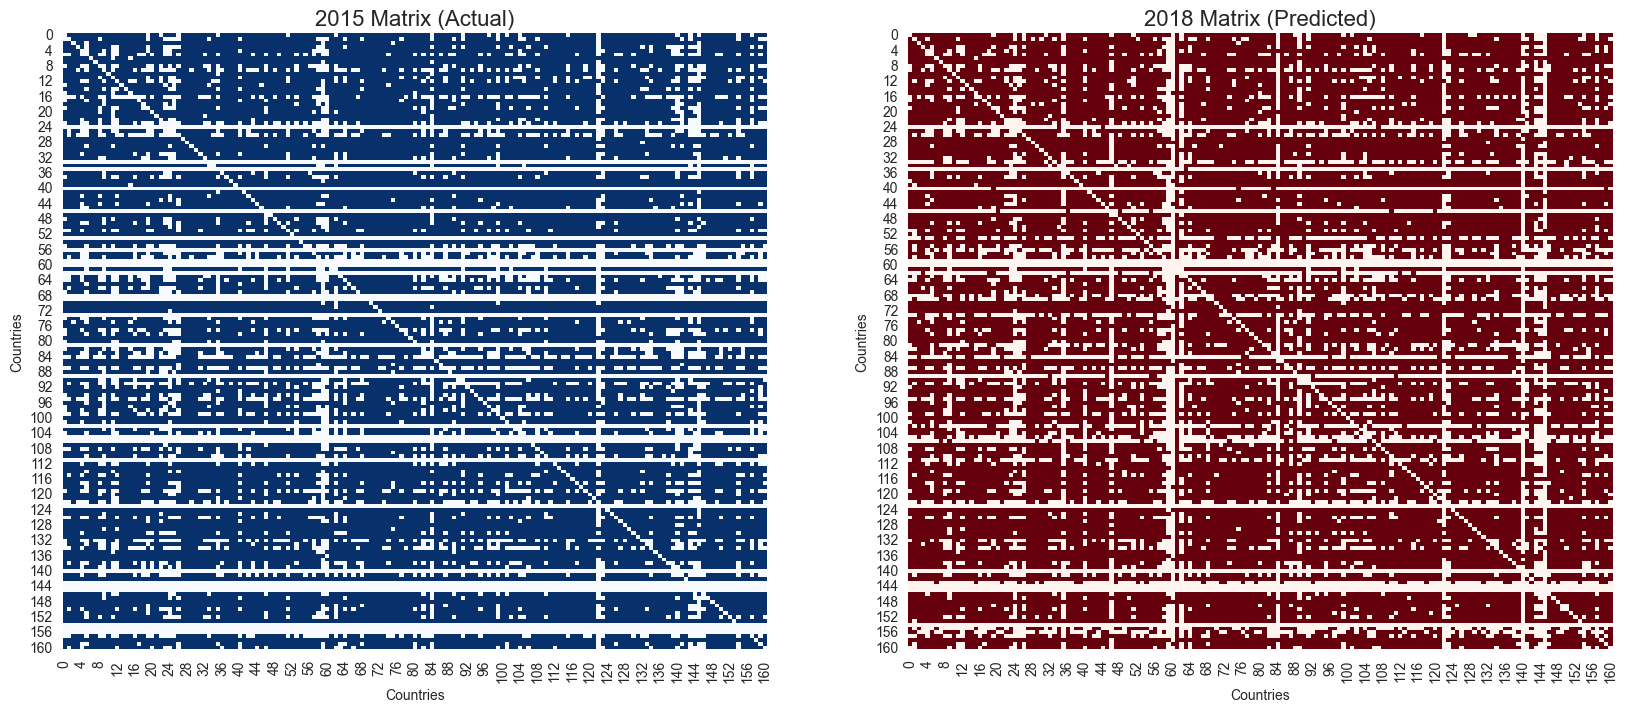

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

def plot_adjacency_heatmap(G1, G2, title1, title2):
    # Get nodes in same order for both
    nodes = sorted(G1.nodes())
    
    # Convert to matrices
    adj1 = nx.to_numpy_array(G1, nodelist=nodes, weight=None) # Binary (0/1)
    adj2 = nx.to_numpy_array(G2, nodelist=nodes, weight=None)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1
    sns.heatmap(adj1, ax=axes[0], cmap="Blues", cbar=False)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel("Countries")
    axes[0].set_ylabel("Countries")
    
    # Plot 2
    sns.heatmap(adj2, ax=axes[1], cmap="Reds", cbar=False)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel("Countries")
    axes[1].set_ylabel("Countries")
    
    plt.show()

# Run it
plot_adjacency_heatmap(G_2015, G_2018_Predicted, "2015 Matrix (Actual)", "2018 Matrix (Predicted)")

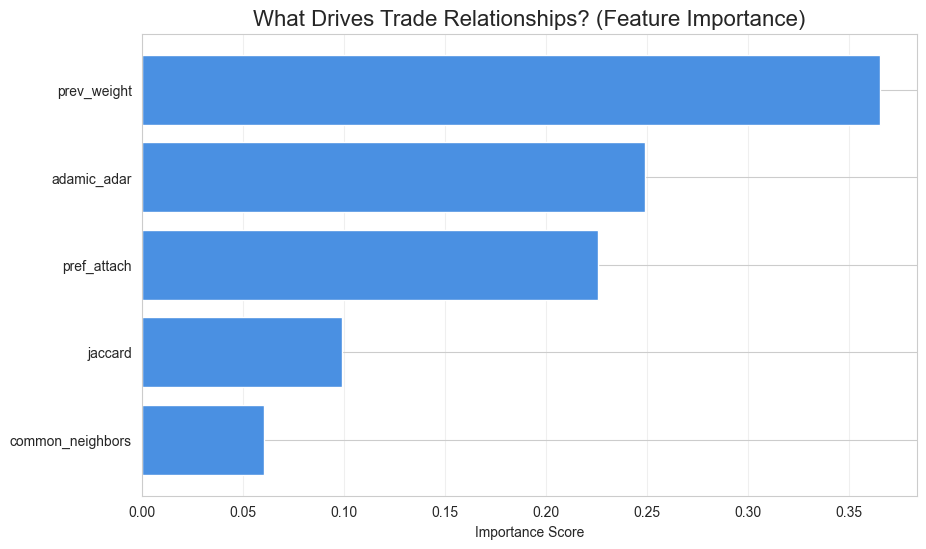

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(clf, feature_names):
    # Get importance from the trained model
    importances = clf.feature_importances_
    
    # Create a DataFrame for easy plotting
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df_imp = df_imp.sort_values('Importance', ascending=True)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(df_imp['Feature'], df_imp['Importance'], color='#4A90E2')
    plt.title('What Drives Trade Relationships? (Feature Importance)', fontsize=16)
    plt.xlabel('Importance Score')
    plt.grid(axis='x', alpha=0.3)
    plt.show()

# Run it (using variables from your previous training step)
features = ['prev_weight', 'common_neighbors', 'jaccard', 'adamic_adar', 'pref_attach']
plot_feature_importance(clf, features)

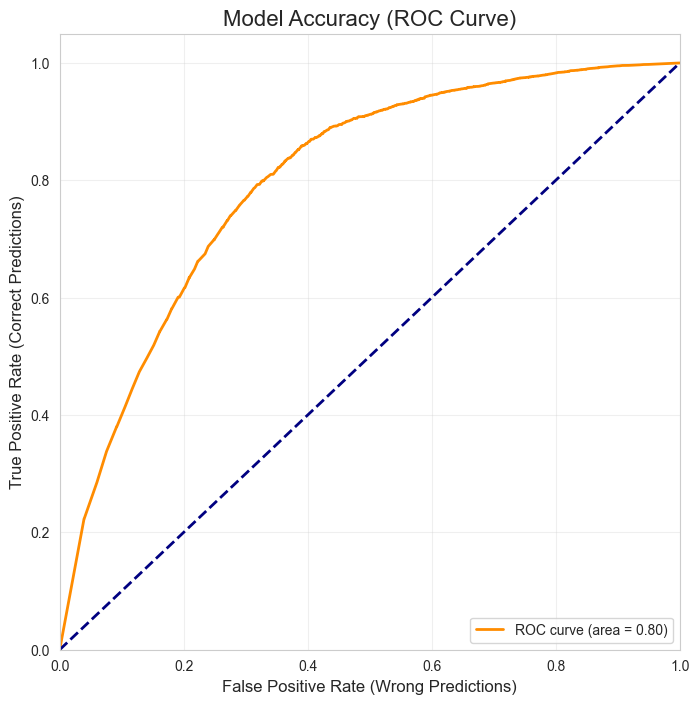

In [72]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Wrong Predictions)', fontsize=12)
    plt.ylabel('True Positive Rate (Correct Predictions)', fontsize=12)
    plt.title('Model Accuracy (ROC Curve)', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Run it
# y_pred_proba comes from the earlier step: clf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba)

## Deep Learning Method

In [77]:
# ------------- 2) Deep Learning: Temporal Graph Autoencoder (train on multiple transitions) -------------
# We align nodes by common_nodes, build features for each year,
# and train encoder to map features_t -> adjacency_{t+1} (binary)

print("Building features and adjacency matrices aligned to common nodes...")
Feats = {}
Adj = {}
Gmap = {"2000":G2000,"2005":G2005,"2010":G2010,"2015":G2015,"2018":G2018}

for y in years:
    G = Gmap[y]
    Feats[y] = build_node_features(G, common_nodes)   # N x F
    # FIX 1: Convert weighted adjacency → BINARY adjacency
    Adj[y] = (build_adj_matrix(G, common_nodes) > 0).astype(float)  # N x N (0/1)


# Training transitions (temporal learning)
train_transitions = [("2000","2005"), ("2005","2010"), ("2010","2015")]
test_transition = ("2015","2018")


# Try importing TensorFlow
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, optimizers
    tf.get_logger().setLevel('ERROR')
    use_tf = True
except:
    print("TensorFlow not available")
    use_tf = False


if use_tf:

    input_dim = Feats["2000"].shape[1]
    emb_dim = 32

    tf.keras.backend.clear_session()

    # ----------- Encoder Model ------------
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inp)
    x = layers.Dense(emb_dim, activation='relu')(x)
    encoder = models.Model(inputs=inp, outputs=x)
    opt = optimizers.Adam(learning_rate=1e-3)

    train_vars = encoder.trainable_variables

    # Build training tensors
    train_feats_list = []
    train_adj_flat_list = []

    for (src, tgt) in train_transitions:
        train_feats_list.append(Feats[src].astype(np.float32))
        # Flatten binary adjacency
        train_adj_flat_list.append(Adj[tgt].astype(np.float32).reshape(-1))

    epochs = 150
    print("Training Temporal GAE on:", train_transitions)

    @tf.function
    def train_step(feats, adj_flat):
        with tf.GradientTape() as tape:
            Z = encoder(feats, training=True)             # (N, emb)

            # -------- FIX 2: Normalize logits --------
            logits = tf.matmul(Z, Z, transpose_b=True) / tf.sqrt(tf.cast(emb_dim, tf.float32))

            # -------- FIX 3: Clip logits to avoid overflow --------
            logits = tf.clip_by_value(logits, -10, 10)

            logits_flat = tf.reshape(logits, [-1])

            # BCE loss (labels are 0/1 now)
            loss = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=adj_flat, logits=logits_flat
            )
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(loss, train_vars)
        opt.apply_gradients(zip(grads, train_vars))
        return loss


    # Training Loop
    for ep in range(1, epochs+1):
        ep_losses = []
        for feats_np, adj_flat_np in zip(train_feats_list, train_adj_flat_list):
            l = train_step(tf.constant(feats_np), tf.constant(adj_flat_np))
            ep_losses.append(l.numpy())

        if ep == 1 or ep % 20 == 0:
            print(f"Epoch {ep}/{epochs}, losses:", [round(v,5) for v in ep_losses])

    print("Training Finished.")


    # ------------ INFERENCE (2015 → 2018) ------------
    Z_test = encoder(Feats["2015"].astype(np.float32), training=False).numpy()

    logits_test = np.matmul(Z_test, Z_test.T) / np.sqrt(emb_dim)
    logits_test = np.clip(logits_test, -10, 10)
    probs_test = 1/(1+np.exp(-logits_test))

    # Ground Truth (binary)
    A_true_test = Adj["2018"]

    y_true_pairs = []
    y_score_pairs = []

    N = len(common_nodes)

    for i, j in itertools.permutations(range(N), 2):
        y_true_pairs.append(int(A_true_test[i, j] == 1))
        y_score_pairs.append(probs_test[i, j])

    y_true_pairs = np.array(y_true_pairs)
    y_score_pairs = np.array(y_score_pairs)

    auc_dl = roc_auc_score(y_true_pairs, y_score_pairs)
    ap_dl = average_precision_score(y_true_pairs, y_score_pairs)

    print("DL (Temporal GAE) Test ROC-AUC:", round(auc_dl,4))
    print("DL (Temporal GAE) Average Precision:", round(ap_dl,4))

else:
    print("TensorFlow not installed — cannot run DL model.")


Building features and adjacency matrices aligned to common nodes...
Training Temporal GAE on: [('2000', '2005'), ('2005', '2010'), ('2010', '2015')]
Epoch 1/150, losses: [np.float32(0.67657), np.float32(0.66848), np.float32(0.66693)]
Epoch 20/150, losses: [np.float32(0.59203), np.float32(0.54726), np.float32(0.57013)]
Epoch 40/150, losses: [np.float32(0.5381), np.float32(0.49742), np.float32(0.53001)]
Epoch 60/150, losses: [np.float32(0.50425), np.float32(0.46699), np.float32(0.5079)]
Epoch 80/150, losses: [np.float32(0.49626), np.float32(0.46136), np.float32(0.50448)]
Epoch 100/150, losses: [np.float32(0.49414), np.float32(0.46005), np.float32(0.50388)]
Epoch 120/150, losses: [np.float32(0.49309), np.float32(0.45921), np.float32(0.50356)]
Epoch 140/150, losses: [np.float32(0.49241), np.float32(0.45866), np.float32(0.5039)]
Training Finished.
DL (Temporal GAE) Test ROC-AUC: 0.7804
DL (Temporal GAE) Average Precision: 0.8693


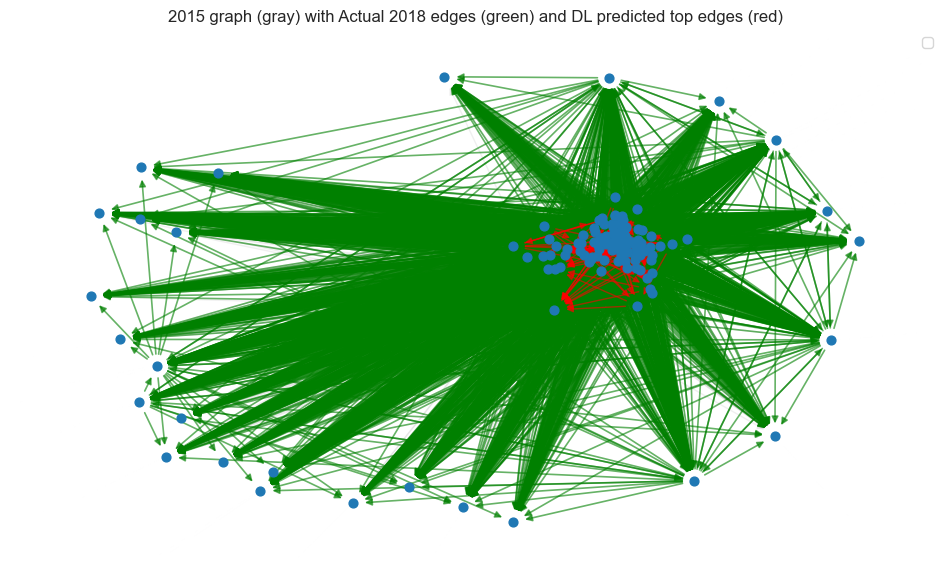

In [78]:
# ------------- 3) Graph visualisation of predicted edges (use test transition 2015->2018) -------------
# Plot 2015 (base), overlay: actual 2018 edges (green), DL predicted top-k (red)
plt.figure(figsize=(12,7))
subG2015 = G2015.subgraph(common_nodes).copy()
nx.draw_networkx_nodes(subG2015, pos, node_size=40)
nx.draw_networkx_edges(subG2015, pos, edge_color='lightgray', alpha=0.35)

# actual 2018 edges among our nodes
true_edges = []
A_true = Adj["2018"]
for i,j in itertools.product(range(len(common_nodes)), range(len(common_nodes))):
    if A_true[i,j] > 0:
        true_edges.append((common_nodes[i], common_nodes[j]))
nx.draw_networkx_edges(subG2015, pos, edgelist=true_edges, edge_color='green', alpha=0.6, width=1.2, label='Actual 2018')

# predicted top-k edges (if DL ran)
if use_tf:
    # mask out edges that already exist in 2015 (we want new predictions)
    A_2015_mat = Adj["2015"]
    cand = []
    N = probs_test.shape[0]
    for i in range(N):
        for j in range(N):
            if i==j: continue
            if A_2015_mat[i,j] > 0: continue
            cand.append(((common_nodes[i], common_nodes[j]), probs_test[i,j]))
    cand_sorted = sorted(cand, key=lambda x: x[1], reverse=True)
    K = min(200, len(cand_sorted))
    pred_top = [e for e,s in cand_sorted[:K]]
    nx.draw_networkx_edges(subG2015, pos, edgelist=pred_top, edge_color='red', alpha=0.6, width=1.0, label=f'Predicted top {K}')
plt.title("2015 graph (gray) with Actual 2018 edges (green) and DL predicted top edges (red)")
plt.legend(); plt.axis('off'); plt.show()

TP edges (correct predictions): 41
FP edges (wrong predictions): 39


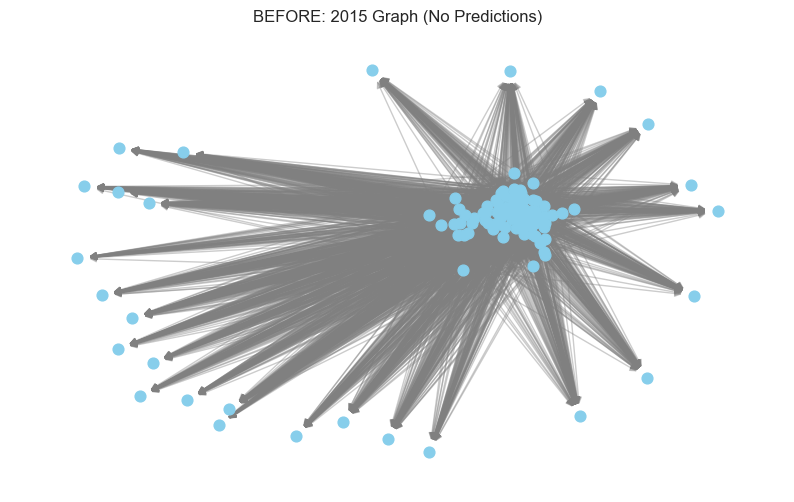

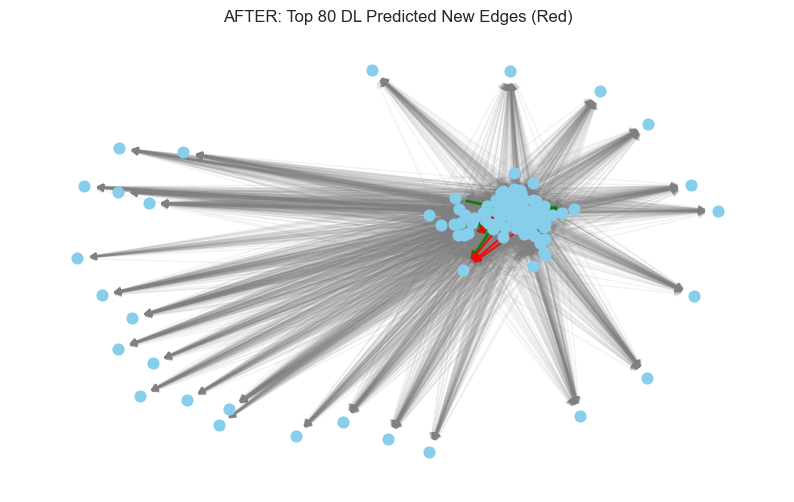

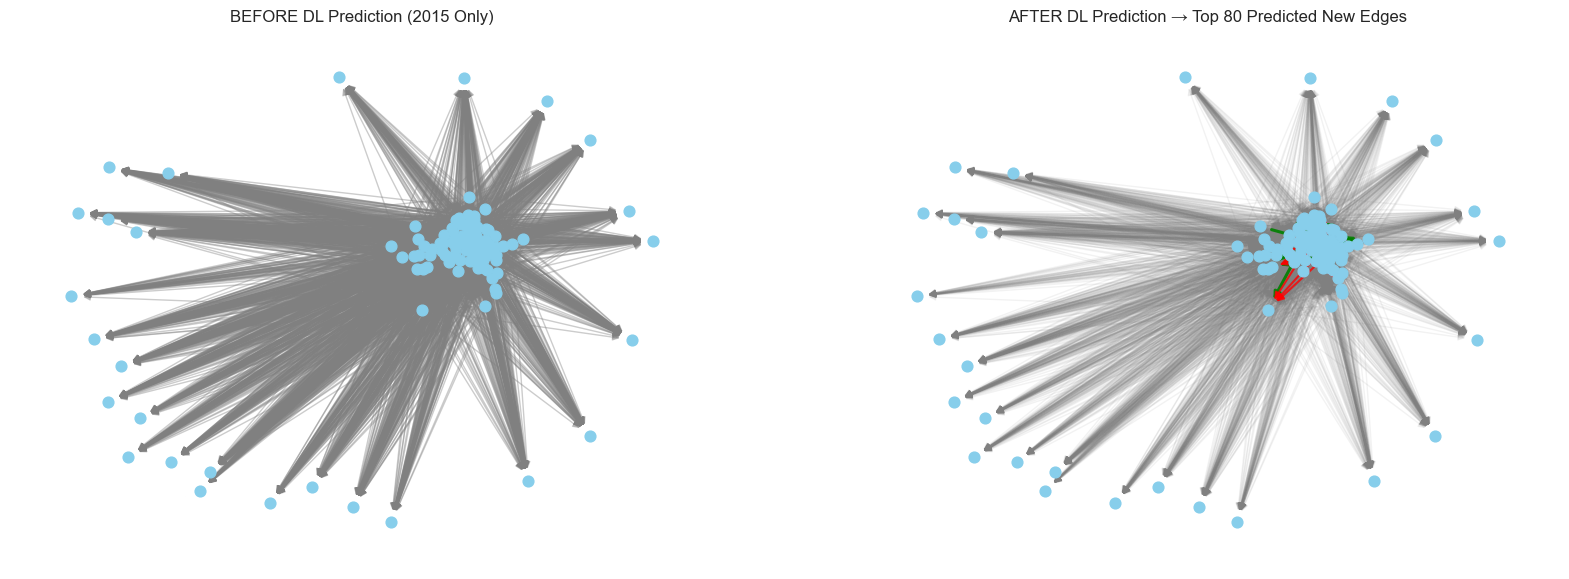

In [79]:
# ========== Improved Clear Graph Visualizations ==========

subG2015 = G2015.subgraph(common_nodes).copy()

# Compute positions if not already computed
pos = nx.spring_layout(subG2015, seed=42, iterations=50)

# ====== CLASSIFY predicted edges into TP (green) and FP (red) ======
A15 = Adj["2015"]
A18 = Adj["2018"]

TP_edges = []   # ground truth new edges correctly predicted
FP_edges = []   # predicted edges that did not occur

# Generate all candidate new edges
candidates = []
N = probs_test.shape[0]

for i in range(N):
    for j in range(N):
        if i == j: 
            continue
        # skip edges that already existed in 2015
        if A15[i,j] == 1:
            continue
        candidates.append(((common_nodes[i], common_nodes[j]), probs_test[i,j]))

# sort by probability
candidates_sorted = sorted(candidates, key=lambda x: x[1], reverse=True)
K = 80
top_preds = candidates_sorted[:K]

# separate TP / FP
for (u,v), score in top_preds:
    i = common_nodes.index(u)
    j = common_nodes.index(v)

    if A18[i,j] == 1:
        TP_edges.append((u,v))   # These edges actually appeared in 2018
    else:
        FP_edges.append((u,v))   # These predictions were wrong

print(f"TP edges (correct predictions): {len(TP_edges)}")
print(f"FP edges (wrong predictions): {len(FP_edges)}")

    

# --------------------- BEFORE ONLY (2015) --------------------
plt.figure(figsize=(10,6))
nx.draw_networkx_nodes(subG2015, pos, node_size=60, node_color='skyblue')
nx.draw_networkx_edges(subG2015, pos, edge_color='gray', alpha=0.4)
plt.title("BEFORE: 2015 Graph (No Predictions)")
plt.axis('off')
plt.show()


# --------------------- AFTER ONLY (Predicted Edges) --------------------
plt.figure(figsize=(10,6))
nx.draw_networkx_nodes(subG2015, pos, node_size=60, node_color='skyblue')
nx.draw_networkx_edges(subG2015, pos, edge_color='gray', alpha=0.1)

# True Positives → Green
nx.draw_networkx_edges(subG2015, pos, edgelist=TP_edges,
                       edge_color='green', width=2.0, alpha=0.9)

# False Positives → Red
nx.draw_networkx_edges(subG2015, pos, edgelist=FP_edges,
                       edge_color='red', width=1.5, alpha=0.9)


plt.title(f"AFTER: Top {K} DL Predicted New Edges (Red)")
plt.axis('off')
plt.show()


# --------------------- SIDE-BY-SIDE ------------------------
plt.figure(figsize=(20,7))

# LEFT: BEFORE
plt.subplot(1,2,1)
nx.draw_networkx_nodes(subG2015, pos, node_size=60, node_color='skyblue')
nx.draw_networkx_edges(subG2015, pos, edge_color='gray', alpha=0.4)
plt.title("BEFORE DL Prediction (2015 Only)")
plt.axis('off')

# RIGHT: AFTER
plt.subplot(1,2,2)
nx.draw_networkx_nodes(subG2015, pos, node_size=60, node_color='skyblue')
nx.draw_networkx_edges(subG2015, pos, edge_color='gray', alpha=0.1)
nx.draw_networkx_edges(subG2015, pos, edgelist=TP_edges,
                       edge_color='green', width=2.2, alpha=0.9, label='Correct Predictions')

nx.draw_networkx_edges(subG2015, pos, edgelist=FP_edges,
                       edge_color='red', width=1.5, alpha=0.8, label='Wrong Predictions')

plt.title(f"AFTER DL Prediction → Top {K} Predicted New Edges")
plt.axis('off')

plt.show()


ML training pairs: 77280 positives: 53841
Training RandomForest on sampled pair-features...
ML RandomForest Test ROC-AUC: 0.8061 AP: 0.8741
Classification report (ML on sampled test):
              precision    recall  f1-score   support

           0       0.80      0.38      0.52      8730
           1       0.75      0.95      0.84     17030

    accuracy                           0.76     25760
   macro avg       0.77      0.67      0.68     25760
weighted avg       0.77      0.76      0.73     25760


--- Comparison summary ---
| Method            |   ROC-AUC |   Average Precision |
|-------------------|-----------|---------------------|
| RandomForest (ML) |    0.8061 |              0.8741 |
| Temporal GAE (DL) |    0.7804 |              0.8693 |


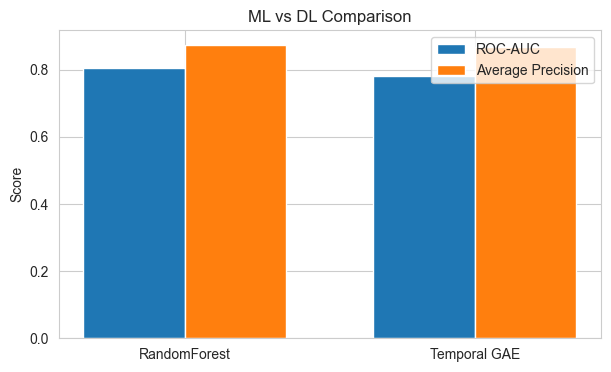

RandomForest feature importances:
 - prev_weight: 0.3378
 - common_neighbors: 0.0721
 - jaccard: 0.1016
 - adamic_adar: 0.2311
 - pref_attach: 0.2573
All done. Inspect the plots and printed metrics above.


In [80]:
# ------------- 4) ML baseline using multiple transitions and comparison -------------
# Build ML training data by sampling pairs for each training transition
# CAUTION: Using all pairs is O(N^2) (may be heavy). We'll sample negative pairs to balance.
def sample_pairs_for_transition(G_src, G_tgt, nodes, neg_ratio=1.0, random_state=42):
    """Return list of pairs (u,v) and labels (1/0). Sample negatives randomly."""
    rng = np.random.default_rng(random_state)
    # all possible ordered pairs
    all_pairs = [(u,v) for u in nodes for v in nodes if u!=v]
    true_pairs = set(G_tgt.subgraph(nodes).edges())
    positive = [p for p in all_pairs if p in true_pairs]
    num_pos = len(positive)
    # sample negatives (pairs not in true_pairs), control number by neg_ratio
    neg_candidates = [p for p in all_pairs if p not in true_pairs]
    num_neg = int(num_pos * neg_ratio) if num_pos>0 else min(5000, len(neg_candidates))
    neg_sample = list(rng.choice(len(neg_candidates), size=min(num_neg, len(neg_candidates)), replace=False))
    negatives = [neg_candidates[i] for i in neg_sample]
    pairs = positive + negatives
    labels = [1]*len(positive) + [0]*len(negatives)
    return pairs, labels

# Prepare ML training data across train_transitions (concatenate)
pairs_train = []
labels_train = []
for t_src, t_tgt in train_transitions:
    p, l = sample_pairs_for_transition(Gmap[t_src], Gmap[t_tgt], common_nodes, neg_ratio=2.0)
    pairs_train.extend(p); labels_train.extend(l)
print("ML training pairs:", len(pairs_train), "positives:", sum(labels_train))

# Feature extraction for ML training and test
X_train_ml = extract_pair_features_for_pairs(Gmap["2000"], common_nodes, pairs_train)  # using source graph 2000 as baseline for features; but better to compute features per transition - simplified here
y_train_ml = np.array(labels_train)

# For test, use transition 2015->2018
pairs_test, labels_test = sample_pairs_for_transition(G2015, G2018, common_nodes, neg_ratio=2.0)
X_test_ml = extract_pair_features_for_pairs(G2015, common_nodes, pairs_test)
y_test_ml = np.array(labels_test)

# Train RandomForest
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
print("Training RandomForest on sampled pair-features...")
clf.fit(X_train_ml, y_train_ml)
y_score_ml = clf.predict_proba(X_test_ml)[:,1]
y_pred_ml = clf.predict(X_test_ml)
auc_ml = roc_auc_score(y_test_ml, y_score_ml)
ap_ml = average_precision_score(y_test_ml, y_score_ml)
print("ML RandomForest Test ROC-AUC:", round(auc_ml,4), "AP:", round(ap_ml,4))
print("Classification report (ML on sampled test):")
print(classification_report(y_test_ml, y_pred_ml, zero_division=0))

# ------------- Summary comparison & graphs -------------
print("\n--- Comparison summary ---")
rows = [
    ["RandomForest (ML)", f"{auc_ml:.4f}", f"{ap_ml:.4f}"],
    ["Temporal GAE (DL)", f"{auc_dl:.4f}" if auc_dl is not None else "n/a", f"{ap_dl:.4f}" if ap_dl is not None else "n/a"]
]
print(tabulate(rows, headers=["Method","ROC-AUC","Average Precision"], tablefmt="github"))

# Bar chart
methods = ["RandomForest", "Temporal GAE"]
auc_vals = [auc_ml, auc_dl if auc_dl is not None else 0]
ap_vals  = [ap_ml, ap_dl if ap_dl is not None else 0]
x = np.arange(len(methods)); width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, auc_vals, width, label='ROC-AUC')
plt.bar(x + width/2, ap_vals, width, label='Average Precision')
plt.xticks(x, methods); plt.ylabel('Score'); plt.title('ML vs DL Comparison'); plt.legend(); plt.show()

# Print RF feature importances
feat_names = ['prev_weight','common_neighbors','jaccard','adamic_adar','pref_attach']
print("RandomForest feature importances:")
for n,imp in zip(feat_names, clf.feature_importances_):
    print(f" - {n}: {imp:.4f}")

print("All done. Inspect the plots and printed metrics above.")

In [45]:
%pip install -q pyvis

Note: you may need to restart the kernel to use updated packages.


1. Loading Data...
   - Loaded 2000: 161 countries
   - Loaded 2005: 161 countries
   - Loaded 2010: 161 countries
   - Loaded 2015: 161 countries
   - Loaded 2018: 161 countries

2. Generating Trend Analysis Graph...
   - Top 5 Influential Countries in 2018: ['CHN', 'USA', 'DEU', 'JPN', 'FRA']


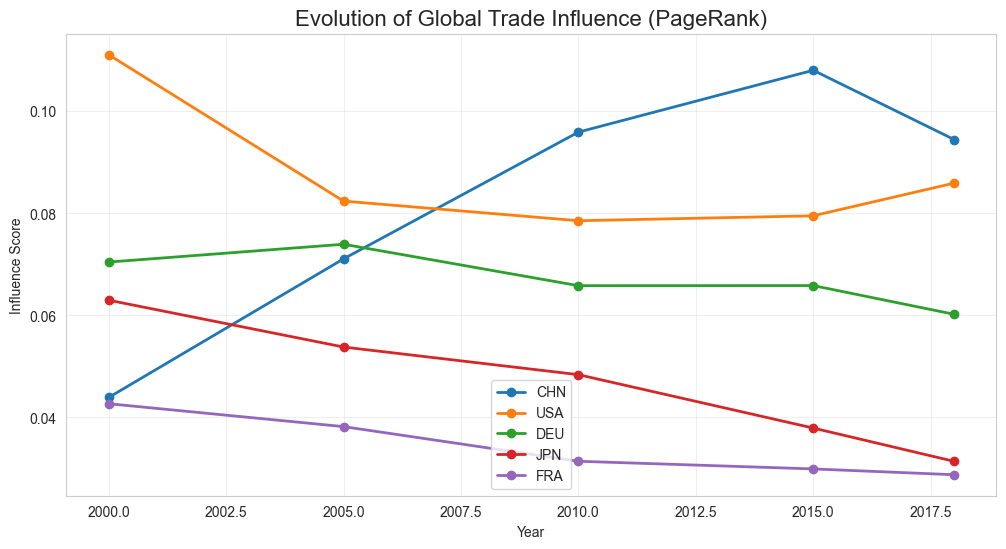


3. Detecting Trade Communities in 2018...
   --- Major Trade Blocs in 2018 ---
   Bloc 1 (71 countries): AGO, ARE, AUS, BDI, BEN, BGD, BHR, BRN, BTN, BWA...
   Bloc 2 (57 countries): ALB, ARM, AUT, AZE, BEL, BFA, BGR, BIH, BLR, CAF...
   Bloc 3 (33 countries): ARG, ATG, BHS, BMU, BOL, BRA, BRB, CAN, CHL, COL...

4. Simulating Economic Shock (Removing 'USA')...
   - Network Density BEFORE removing USA: 0.6611
   - Network Density AFTER removing USA:  0.6586
   - Impact: Connectivity dropped by 0.38%


In [56]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

# --- 1. LOAD THE DATA ---
print("1. Loading Data...")
files = ['/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2000.net', '/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2005.net', '/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2010.net', '/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2015.net', '/Users/aishwarysinghrathour/Desk/TRimester_5/Graph_Analytics/Project/archive/2018.net']
years = [2000, 2005, 2010, 2015, 2018]
graphs = {}

def load_pajek_graph(filepath):
    try:
        # Read file
        G_multi = nx.read_pajek(filepath)
        G = nx.DiGraph()
        # Fix potential multi-edge issues
        for u, v, data in G_multi.edges(data=True):
            weight = data.get('weight', 1.0)
            if G.has_edge(u, v):
                G[u][v]['weight'] += weight
            else:
                G.add_edge(u, v, weight=weight)
        return G
    except Exception as e:
        print(f"Failed to load {filepath}: {e}")
        return None

# Load all files into a dictionary
for file, year in zip(files, years):
    g = load_pajek_graph(file)
    if g:
        graphs[year] = g
        print(f"   - Loaded {year}: {len(g.nodes())} countries")

# --- 2. RUN TREND ANALYSIS (The Rise & Fall) ---
print("\n2. Generating Trend Analysis Graph...")

def analyze_dominance_trends(graph_dict):
    data = []
    for year, G in graph_dict.items():
        # Calculate PageRank (Influence)
        pr = nx.pagerank(G, weight='weight')
        for country, score in pr.items():
            data.append({'Year': year, 'Country': country, 'Score': score})
    
    df = pd.DataFrame(data)
    
    # Find the top 5 countries in 2018
    final_year_data = df[df['Year'] == 2018]
    if final_year_data.empty:
        print("   Error: No data for 2018 found.")
        return

    top_countries = final_year_data.nlargest(5, 'Score')['Country'].tolist()
    print(f"   - Top 5 Influential Countries in 2018: {top_countries}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    for country in top_countries:
        trajectory = df[df['Country'] == country]
        plt.plot(trajectory['Year'], trajectory['Score'], marker='o', label=country, linewidth=2)
        
    plt.title("Evolution of Global Trade Influence (PageRank)", fontsize=16)
    plt.xlabel("Year")
    plt.ylabel("Influence Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# CALL THE FUNCTION
if graphs:
    analyze_dominance_trends(graphs)


# --- 3. RUN COMMUNITY DETECTION (Trade Blocs) ---
print("\n3. Detecting Trade Communities in 2018...")

def find_trade_blocs(G, year):
    if not G: return
    
    # Convert to undirected for community detection
    G_undir = G.to_undirected()
    
    # Greedy Modularity method
    communities = list(greedy_modularity_communities(G_undir, weight='weight'))
    
    print(f"   --- Major Trade Blocs in {year} ---")
    count = 1
    for c in communities:
        # Only print communities with more than 5 countries
        if len(c) > 5:
            # Convert to list and sort to make it readable
            members = sorted(list(c))
            # Print first 10 members
            preview = ", ".join(members[:10])
            print(f"   Bloc {count} ({len(members)} countries): {preview}...")
            count += 1

# CALL THE FUNCTION
if 2018 in graphs:
    find_trade_blocs(graphs[2018], 2018)


# --- 4. RUN SHOCK SIMULATION ---
print("\n4. Simulating Economic Shock (Removing 'USA')...")

def simulate_shock(G, target_country):
    if target_country not in G:
        print(f"   Error: {target_country} not found in the graph.")
        return
        
    G_shocked = G.copy()
    G_shocked.remove_node(target_country)
    
    # We use 'density' as a proxy for efficiency here because it's faster to calculate
    # (Global efficiency can be slow on large graphs)
    density_before = nx.density(G)
    density_after = nx.density(G_shocked)
    
    drop = (density_before - density_after) / density_before * 100
    print(f"   - Network Density BEFORE removing {target_country}: {density_before:.4f}")
    print(f"   - Network Density AFTER removing {target_country}:  {density_after:.4f}")
    print(f"   - Impact: Connectivity dropped by {drop:.2f}%")

# CALL THE FUNCTION
if 2018 in graphs:
    simulate_shock(graphs[2018], "USA") # You can change "USA" to "CHN" or "DEU"